In [2]:
# General imports
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import MeanSquaredError, MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import Adam

import pydot
import os
from pathlib import Path

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import xgboost as xgb
                
# Project imports
from utils.images_loader import ImagesLoader
from utils.text_data_loader import TextDataLoader
from utils.utilities import plot_history
from utils.utilities import rmsle
from utils.utilities import load_x_y_from_loaders
from model import TextOnlyModel, ImageAndTextModel
from train import IMAGE_INPUT_NAME, TEXT_FEATURES_INPUT_NAME, OUTPUT_NAME



In [9]:
IMAGE_INPUT_NAME

'image'

In [3]:
# Params
use_scaling = True
include_images = True

# data paths
train_text_path = r'./src_data/train.csv'
train_images_folder = r'./src_data/train_profile_images'
test_text_path = r'./src_data/test.csv'
test_images_folder = r'./src_data/test_profile_images'
log_folder = 'logs'

In [4]:
# TRAIN
# Images loader
print('\nTRAIN:')
images_loader = ImagesLoader(src_folder_path = train_images_folder)
print('Number images: {:}'.format(images_loader.nbr_images))
print('Images shape: {:}'.format(images_loader.image_shape))
# Text data loader
text_data_loader = TextDataLoader(src_csv_file_path = train_text_path)

# TEST
# Test Images loader
print('\nTEST:')
test_images_loader = ImagesLoader(src_folder_path = test_images_folder)
print('Number images: {:}'.format(test_images_loader.nbr_images))
print('Images shape: {:}'.format(test_images_loader.image_shape))
# Test Text data loader
test_text_data_loader = TextDataLoader(src_csv_file_path = test_text_path)


# Get and profile by its ID
profile_id = '00NJOGS399G79OP3'
image_data = images_loader.get_image_data_for_profile_id(profile_id)
text_data = text_data_loader.get_orig_data_for_profile_id(profile_id)




TRAIN:
Number images: 7500
Images shape: (32, 32, 3)

TEST:
Number images: 2500
Images shape: (32, 32, 3)


In [5]:
# Print data for this profile
#print(text_data)

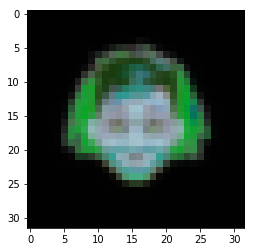

In [6]:
# Show profile image
plt.imshow(image_data)
plt.show()

# Train/Valid split

In [7]:
# -- Split ids to train/valid --
all_profiles_ids_list = text_data_loader.get_transformed_features()['Id'].values

train_profiles_ids, valid_profiles_ids = train_test_split(all_profiles_ids_list, test_size = .2, random_state=5, shuffle=True)

In [8]:
#-- Preare data for model  Train/Valid--
# Will use a dict to associate the corresponding data to the right input in the model (Image vs Features)

# TODO using scaling
if use_scaling:
    sc_x = StandardScaler()
    #sc_x = PowerTransformer(method='box-cox', standardize=False)
    pt_cox_y = PowerTransformer(method='box-cox', standardize=False)

# - Train: use train_profiles_ids
train_X, train_y = load_x_y_from_loaders(images_loader=images_loader,
                                        text_data_loader=text_data_loader,
                                        image_input_name=IMAGE_INPUT_NAME,
                                        text_features_input_name=TEXT_FEATURES_INPUT_NAME,
                                        output_name=OUTPUT_NAME,
                                        profiles_ids_list=train_profiles_ids,
                                        include_images=include_images)
if use_scaling:
    # Fit and Transform on Train
    train_X[TEXT_FEATURES_INPUT_NAME] = sc_x.fit_transform(train_X[TEXT_FEATURES_INPUT_NAME])# + 1) Need to add 1 for Box-Cox
    train_y[OUTPUT_NAME] = pt_cox_y.fit_transform((train_y[OUTPUT_NAME] + 1).reshape(-1, 1))

# - Valid: use valid_profiles_ids
valid_X, valid_y = load_x_y_from_loaders(images_loader=images_loader,
                             text_data_loader=text_data_loader,
                             image_input_name=IMAGE_INPUT_NAME,
                             text_features_input_name=TEXT_FEATURES_INPUT_NAME,
                             output_name=OUTPUT_NAME,
                             profiles_ids_list=valid_profiles_ids,
                             include_images=include_images)

if use_scaling:
    # Transform only on Valid
    valid_X[TEXT_FEATURES_INPUT_NAME] = sc_x.transform(valid_X[TEXT_FEATURES_INPUT_NAME])# + 1) Need to add 1 for Box-Cox
    valid_y[OUTPUT_NAME] = pt_cox_y.transform((valid_y[OUTPUT_NAME] + 1).reshape(-1, 1))


In [9]:
valid_y

{'likes': array([[14.24066983],
        [11.97749272],
        [12.58127727],
        ...,
        [16.25648844],
        [12.24153777],
        [11.6742316 ]])}

In [10]:
valid_y[OUTPUT_NAME]

array([[14.24066983],
       [11.97749272],
       [12.58127727],
       ...,
       [16.25648844],
       [12.24153777],
       [11.6742316 ]])

In [257]:
train_y[OUTPUT_NAME]

array([[ 0.84456286],
       [-0.03593983],
       [-0.7555465 ],
       ...,
       [ 0.08329102],
       [ 0.02438466],
       [-0.46828993]])

# Features analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000220B0B2A748>]],
      dtype=object)

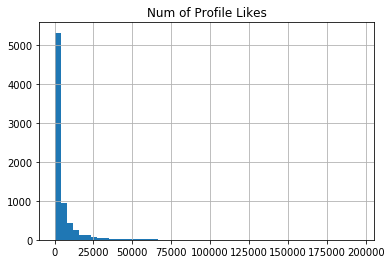

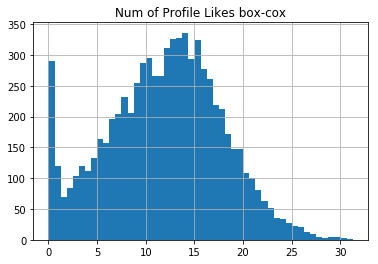

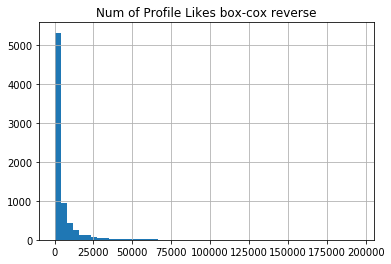

In [283]:
# Num likes analysis
features = text_data_loader.get_transformed_features()

features.hist(column='Num of Profile Likes', log=False, bins=50)

pt_cox = PowerTransformer(method='box-cox', standardize=False)

features['Num of Profile Likes box-cox'] = features['Num of Profile Likes'] + 1 
features['Num of Profile Likes box-cox'] = pt_cox.fit_transform(features['Num of Profile Likes box-cox'].values.reshape(-1, 1))

features.hist(column='Num of Profile Likes box-cox', log=False, bins=50)

features['Num of Profile Likes box-cox reverse'] = (pt_cox.inverse_transform(features['Num of Profile Likes box-cox'].values.reshape(-1, 1))-1)
features.hist(column='Num of Profile Likes box-cox reverse', log=False, bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000220B3D7EA20>]],
      dtype=object)

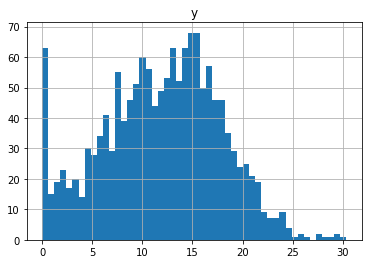

In [284]:
df_y = pd.DataFrame(data=valid_y[OUTPUT_NAME],
                    columns=['y'])
df_y.describe()
df_y.hist(column='y', log=False, bins=50)

In [285]:
orig_columns_names = text_data_loader.get_transformed_features().drop(columns =['Id', 'Num of Profile Likes']).columns.values
columns_nbr = np.array(np.arange(train_X[TEXT_FEATURES_INPUT_NAME].shape[1]))
col_dict = dict(zip(columns_nbr, orig_columns_names))#[{col_nbr: col_name} for col_nbr, col_name in zip(columns_nbr, orig_columns_names)]
df_X = pd.DataFrame(data=train_X[TEXT_FEATURES_INPUT_NAME],    # values
                  columns=columns_nbr)

In [286]:
col_dict

{0: 'Profile Cover Image Status',
 1: 'Is Profile View Size Customized?',
 2: 'Location Public Visibility',
 3: 'Num of Followers',
 4: 'Num of People Following',
 5: 'Num of Status Updates',
 6: 'Num of Direct Messages',
 7: 'Avg Daily Profile Visit Duration in seconds',
 8: 'Avg Daily Profile Clicks',
 9: 'Profile Text Color_r',
 10: 'Profile Text Color_g',
 11: 'Profile Text Color_b',
 12: 'Profile Page Color_r',
 13: 'Profile Page Color_g',
 14: 'Profile Page Color_b',
 15: 'Profile Theme Color_r',
 16: 'Profile Theme Color_g',
 17: 'Profile Theme Color_b',
 18: 'Has Personal URL',
 19: 'Account Age Days',
 20: 'Verification_Status_Not verified',
 21: 'Verification_Status_Pending',
 22: 'Verification_Status_Verified',
 23: 'Category_business',
 24: 'Category_celebrity',
 25: 'Category_government',
 26: 'Category_unknown',
 27: 'Language_ar',
 28: 'Language_de',
 29: 'Language_en',
 30: 'Language_es',
 31: 'Language_fr',
 32: 'Language_it',
 33: 'Language_ja',
 34: 'Language_other',

In [224]:
df_X.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
740,0.557952,-0.31785,-1.184232,0.225054,-0.151694,-0.092749,-0.028615,-0.703577,-0.517368,-0.889377,...,-0.090787,-0.107121,0.624043,-0.363039,-0.174943,-0.124161,-0.130916,-0.17085,-0.185791,-0.14594
5832,0.557952,-0.31785,-1.184232,2.143134,-0.151614,-0.225738,-0.035004,0.510565,-0.980259,-0.889377,...,-0.090787,-0.107121,0.624043,-0.363039,-0.174943,-0.124161,-0.130916,-0.17085,-0.185791,-0.14594
5155,0.557952,-0.31785,0.844429,-0.016363,-0.160331,-0.238455,-0.038175,-1.463719,0.103672,-0.889377,...,-0.090787,-0.107121,0.624043,-0.363039,-0.174943,-0.124161,-0.130916,-0.17085,-0.185791,-0.14594
3228,-1.792269,-0.31785,0.844429,0.397837,-0.166589,-0.202509,0.056952,1.095542,-0.520998,-0.076836,...,-0.090787,-0.107121,0.624043,-0.363039,-0.174943,-0.124161,-0.130916,-0.17085,-0.185791,-0.14594
4507,0.557952,-0.31785,0.844429,-0.253762,-0.150834,0.428704,-0.064411,-0.279828,0.147105,1.087073,...,-0.090787,-0.107121,0.624043,-0.363039,-0.174943,-0.124161,-0.130916,-0.17085,-0.185791,-0.14594


Account Age Days
count    5.994000e+03
mean    -2.121908e-16
std      1.000083e+00
min     -3.877141e+00
25%     -5.707785e-01
50%      2.746004e-01
75%      7.375982e-01
max      2.139308e+00
Name: 19, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000220B5478A90>]],
      dtype=object)

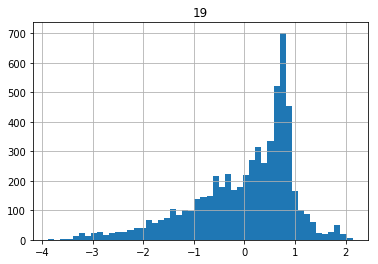

In [225]:
feature_idx = 19
print(col_dict[feature_idx])
print(df_X[feature_idx].describe())
df_X.hist(column=feature_idx, log=False, bins=50)

Language_tr
count    5.994000e+03
mean     3.556270e-17
std      1.000083e+00
min     -1.459395e-01
25%     -1.459395e-01
50%     -1.459395e-01
75%     -1.459395e-01
max      6.852153e+00
Name: 36, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000220B5179EB8>]],
      dtype=object)

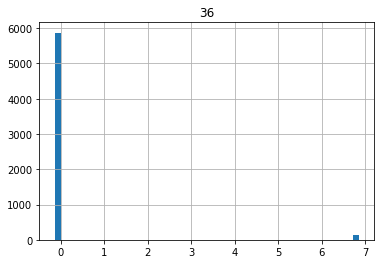

In [226]:
feature_idx = 36
print(col_dict[feature_idx])
print(df_X[feature_idx].describe())
df_X.hist(column=feature_idx, log=False, bins=50)

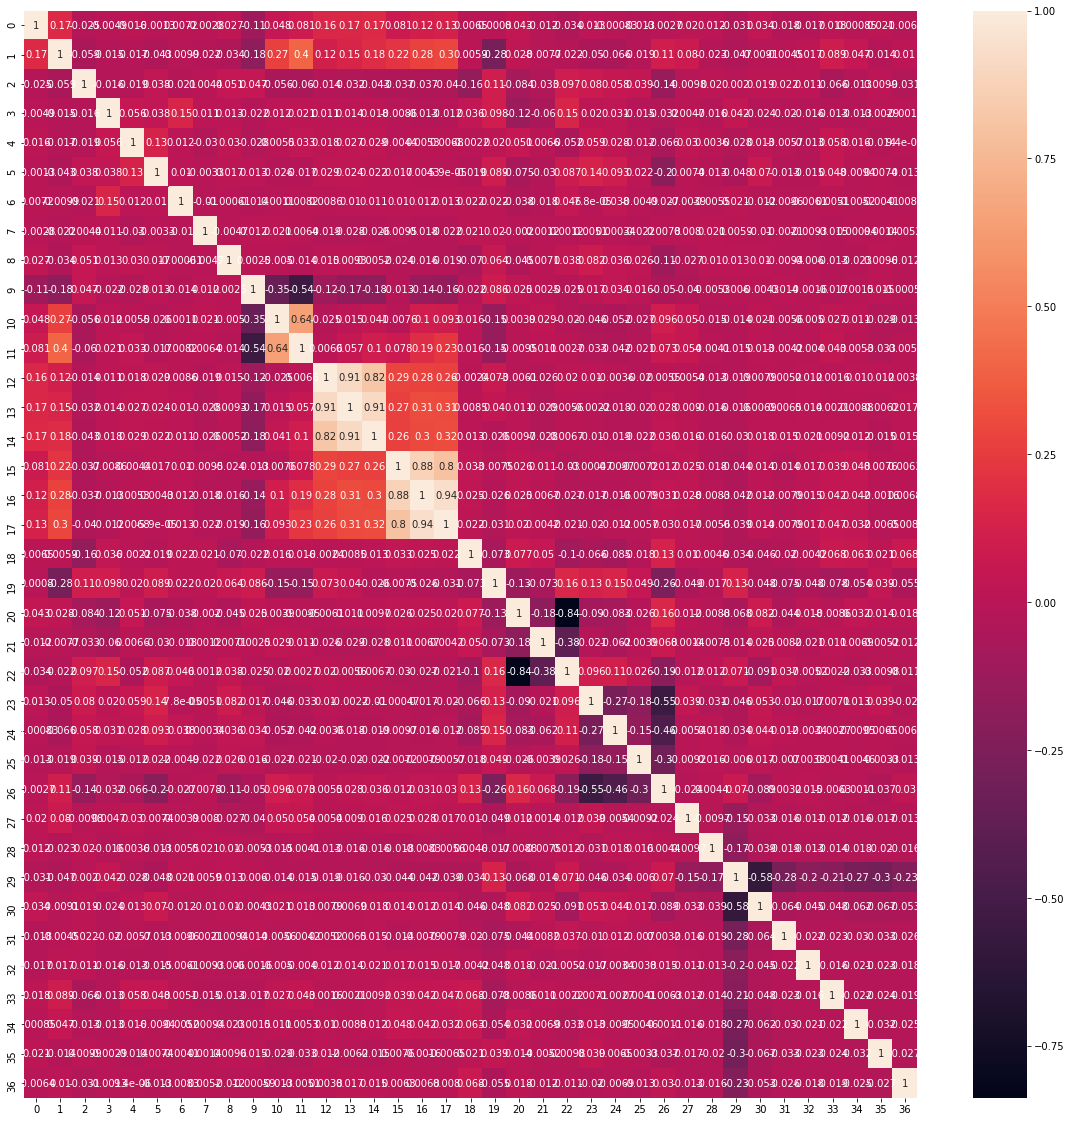

In [227]:
plt.figure(figsize=(20, 20))
sn.heatmap(df_X.corr(), annot=True)
plt.show()

In [228]:
df_all = df_X.copy()
df_all['y'] = df_y['y']
df_all.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36, 'y'],
      dtype='object')

In [229]:
col_dict

{0: 'Profile Cover Image Status',
 1: 'Is Profile View Size Customized?',
 2: 'Location Public Visibility',
 3: 'Num of Followers',
 4: 'Num of People Following',
 5: 'Num of Status Updates',
 6: 'Num of Direct Messages',
 7: 'Avg Daily Profile Visit Duration in seconds',
 8: 'Avg Daily Profile Clicks',
 9: 'Profile Text Color_r',
 10: 'Profile Text Color_g',
 11: 'Profile Text Color_b',
 12: 'Profile Page Color_r',
 13: 'Profile Page Color_g',
 14: 'Profile Page Color_b',
 15: 'Profile Theme Color_r',
 16: 'Profile Theme Color_g',
 17: 'Profile Theme Color_b',
 18: 'Has Personal URL',
 19: 'Account Age Days',
 20: 'Verification_Status_Not verified',
 21: 'Verification_Status_Pending',
 22: 'Verification_Status_Verified',
 23: 'Category_business',
 24: 'Category_celebrity',
 25: 'Category_government',
 26: 'Category_unknown',
 27: 'Language_ar',
 28: 'Language_de',
 29: 'Language_en',
 30: 'Language_es',
 31: 'Language_fr',
 32: 'Language_it',
 33: 'Language_ja',
 34: 'Language_other',

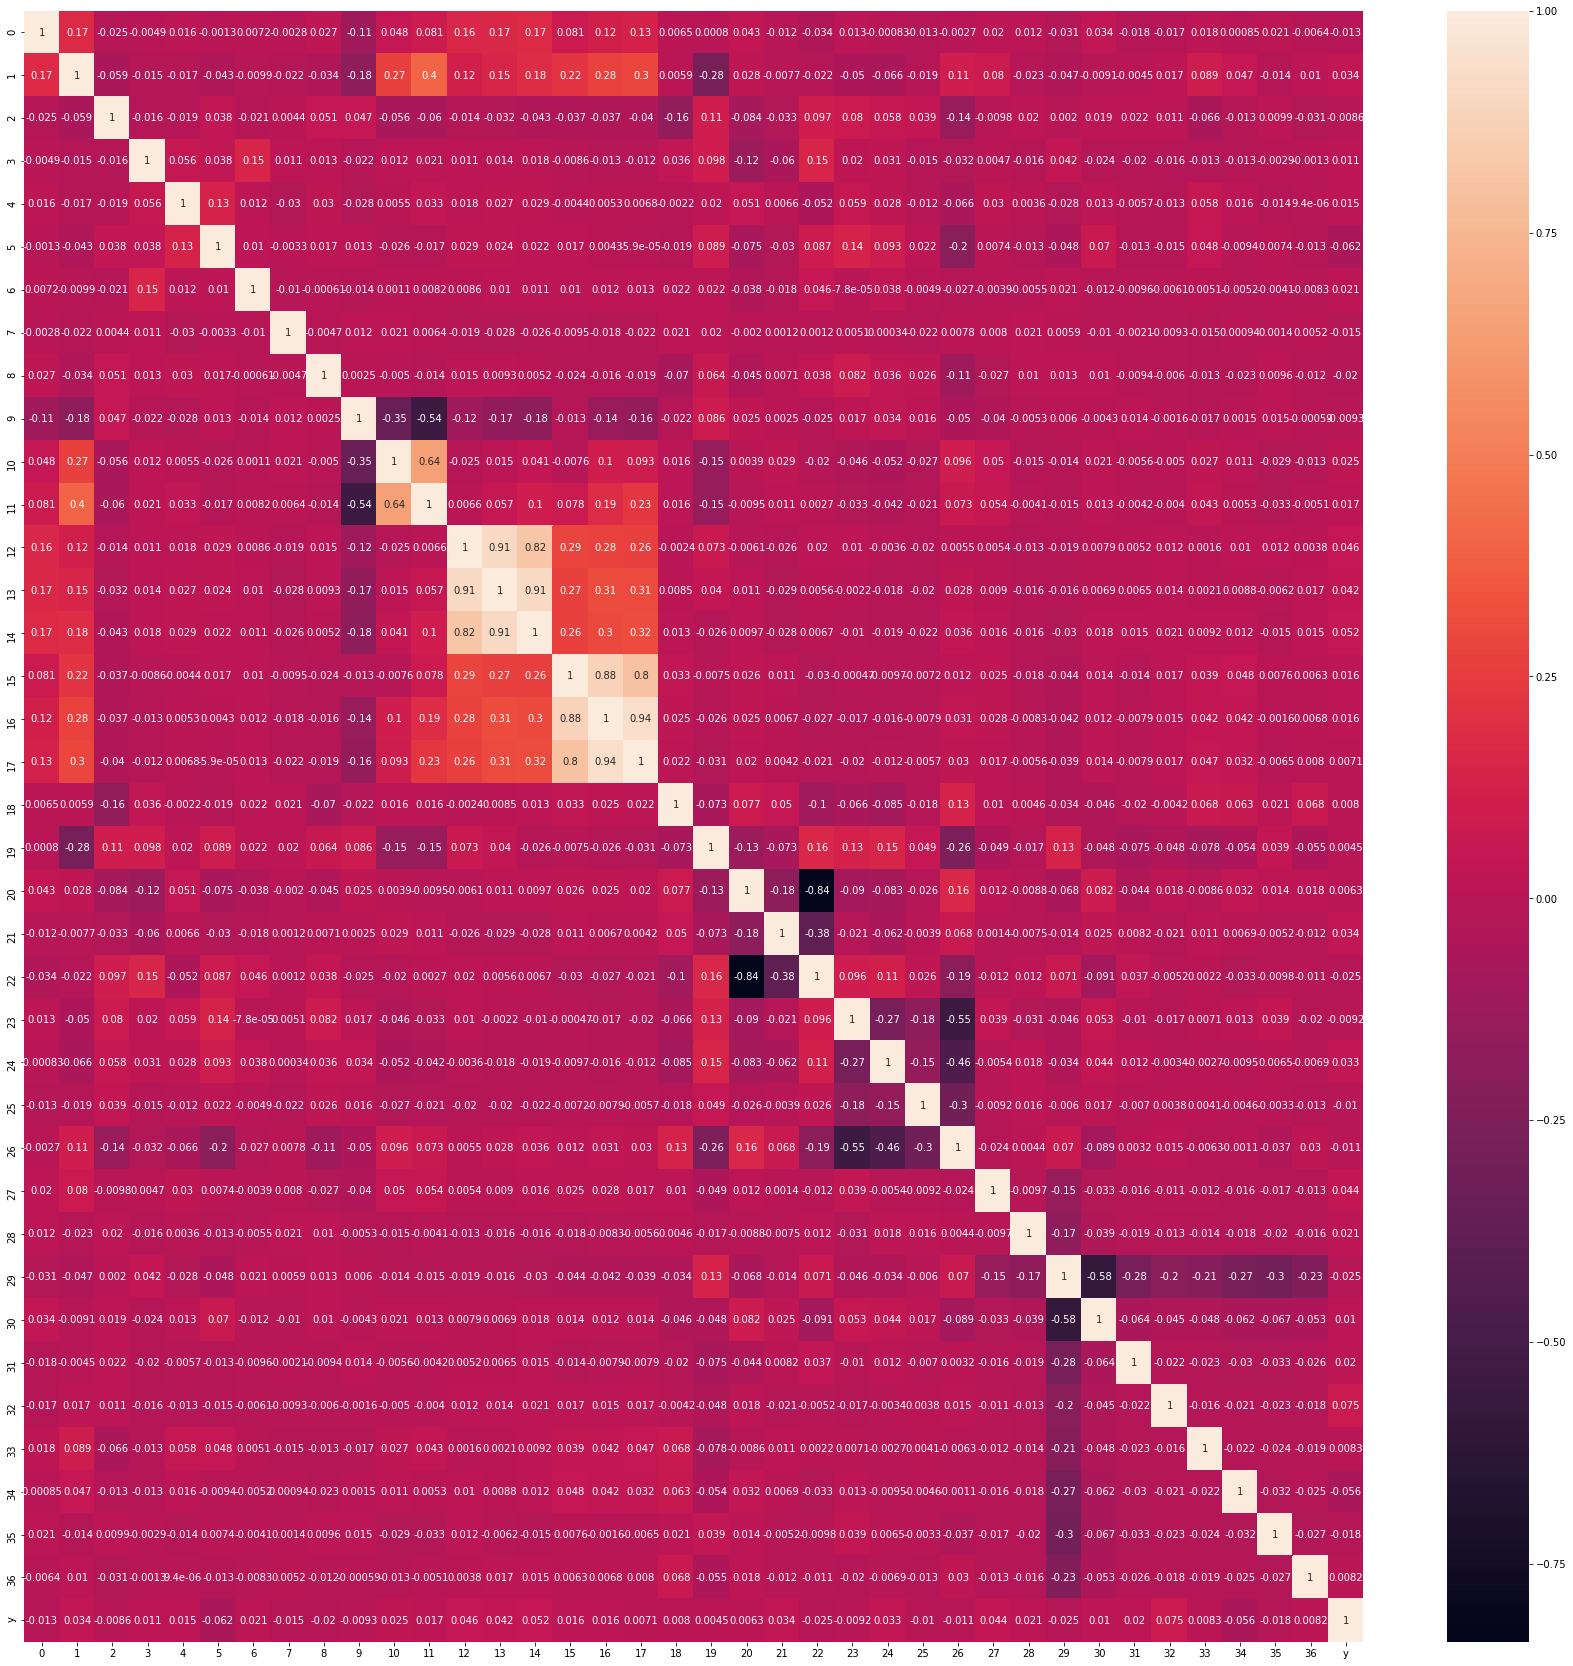

In [230]:
plt.figure(figsize=(30, 30))
sn.heatmap(df_all.corr(), annot=True)
plt.show()

In [231]:
corr_to_y = df_all.corr()
corr_to_y['abs_corr_to_y'] = corr_to_y['y'].abs()

#### TEST Select Top n featrues

In [234]:
nbr_features = 35
best_features_idxs = corr_to_y['abs_corr_to_y'].sort_values(ascending = False).index[1:nbr_features+1].values.astype(int)
best_features_idxs

array([32,  5, 34, 14, 12, 27, 13,  1, 21, 24, 29, 10, 22,  6, 28,  8, 31,
       35, 11, 15, 16,  7,  4,  0, 26,  3, 30, 25,  9, 23,  2, 33, 36, 18,
       17])

In [235]:
for idx in best_features_idxs:
    print(col_dict[idx])

Language_it
Num of Status Updates
Language_other
Profile Page Color_b
Profile Page Color_r
Language_ar
Profile Page Color_g
Is Profile View Size Customized?
Verification_Status_Pending
Category_celebrity
Language_en
Profile Text Color_g
Verification_Status_Verified
Num of Direct Messages
Language_de
Avg Daily Profile Clicks
Language_fr
Language_pt
Profile Text Color_b
Profile Theme Color_r
Profile Theme Color_g
Avg Daily Profile Visit Duration in seconds
Num of People Following
Profile Cover Image Status
Category_unknown
Num of Followers
Language_es
Category_government
Profile Text Color_r
Category_business
Location Public Visibility
Language_ja
Language_tr
Has Personal URL
Profile Theme Color_b


In [236]:
# Backup
#orig_train_X = train_X[TEXT_FEATURES_INPUT_NAME]
#orig_valid_X = valid_X[TEXT_FEATURES_INPUT_NAME]

In [237]:
# Select based on features
#train_X[TEXT_FEATURES_INPUT_NAME] = orig_train_X[:,best_features_idxs]
#valid_X[TEXT_FEATURES_INPUT_NAME] = orig_valid_X[:,best_features_idxs]

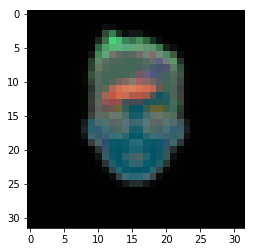

In [61]:
idx = 10

#vX, valid_X
#vy, valid_y
plt.imshow(train_X[IMAGE_INPUT_NAME][idx])
plt.show()

# All data and test data loading

In [14]:
# -- Preare data for model  All DATA and TEST --
all_data_profiles_ids_list = text_data_loader.get_transformed_features()['Id'].values
all_test_profiles_ids_list = test_text_data_loader.get_transformed_features()['Id'].values


# TODO DEBUG using scaling for tests
if use_scaling:
    sc_alldata_x = StandardScaler()
    sc_alldata_y = PowerTransformer(method='box-cox', standardize=False) #StandardScaler()

#- All Train data
data_X, data_y = load_x_y_from_loaders(images_loader=images_loader,
                             text_data_loader=text_data_loader,
                             image_input_name=IMAGE_INPUT_NAME,
                             text_features_input_name=TEXT_FEATURES_INPUT_NAME,
                             output_name=OUTPUT_NAME,
                             profiles_ids_list=all_data_profiles_ids_list,
                             include_images=True)
if use_scaling:
    # Fit and Transform on Train
    data_X[TEXT_FEATURES_INPUT_NAME] = sc_alldata_x.fit_transform(data_X[TEXT_FEATURES_INPUT_NAME])
    data_y[OUTPUT_NAME] = sc_alldata_y.fit_transform((data_y[OUTPUT_NAME] + 1).reshape(-1, 1))


#- Test data
test_X = load_x_y_from_loaders(images_loader=test_images_loader,
                             text_data_loader=test_text_data_loader,
                             image_input_name=IMAGE_INPUT_NAME,
                             text_features_input_name=TEXT_FEATURES_INPUT_NAME,
                             output_name=OUTPUT_NAME,
                             profiles_ids_list=all_test_profiles_ids_list,
                             include_images=True)
if use_scaling:
    # Transform only on Test
    # TODO ERROR SHOULD NOT USE FIT:
    # test_X[TEXT_FEATURES_INPUT_NAME] = sc_alldata_x.fit_transform(test_X[TEXT_FEATURES_INPUT_NAME])
    # FIXED:
    test_X[TEXT_FEATURES_INPUT_NAME] = sc_alldata_x.transform(test_X[TEXT_FEATURES_INPUT_NAME])

In [15]:
all_test_profiles_ids_list

array(['49I3SOKLI2CMNGP4', '727IRIR59A3P88LK', 'LN95SD15SRPCEE8F', ...,
       'SRNIBIK27BQ2M3PB', '6CP232J9R8N84702', 'AROR24MH3M79EHBS'],
      dtype=object)

(32, 32, 3)
[16.74932145]
(32, 32, 3)


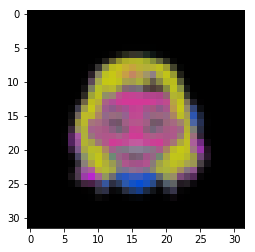

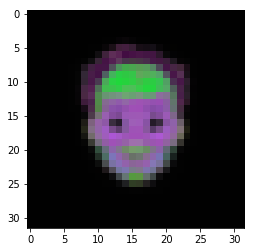

In [11]:
idx = 0
print(train_X[IMAGE_INPUT_NAME][idx].shape)
print(train_y[OUTPUT_NAME][idx])
print(test_X[IMAGE_INPUT_NAME][idx].shape)

plt.imshow(train_X[IMAGE_INPUT_NAME][idx])
plt.show()

plt.imshow(test_X[IMAGE_INPUT_NAME][idx])
plt.show()


# Keras models


In [65]:


# Need to reload model.py in case of changes
import imp
import model
imp.reload(model)
from model import TextOnlyModel, ImageAndTextModel

# GPU specific
os.environ['CUDA_VISIBLE_DEVICES']='1'
# Hyper-params TODO move to json file? for better modularity and tracking
learning_rate = 0.001
training_batch_size = 32 #32
n_epochs = 50



# -- Prepare model --
image_height = images_loader.image_shape[0]
image_width = images_loader.image_shape[1]
image_nbr_channels = images_loader.image_shape[2]
nbr_text_features = train_X[TEXT_FEATURES_INPUT_NAME].shape[1] # TODO text_data_loader.get_nbr_features()


# Text and Image model
if include_images:
    model = ImageAndTextModel(image_height = image_height,
                            image_width = image_width,
                            image_nbr_channels = image_nbr_channels,
                            nbr_text_features = nbr_text_features,
                            image_input_name=IMAGE_INPUT_NAME,
                            text_features_input_name=TEXT_FEATURES_INPUT_NAME,
                            output_name=OUTPUT_NAME)

# Text only model
else :
    model = TextOnlyModel(nbr_text_features = nbr_text_features,
                            text_features_input_name=TEXT_FEATURES_INPUT_NAME,
                            output_name=OUTPUT_NAME)

# Model summary
model.summary() # TODO model summary to file
plot_model(model, os.path.join(log_folder, 'model.png'), show_shapes=True)

# -- Compile model --
model.compile(loss=MeanSquaredLogarithmicError(), #MeanSquaredError(),
                optimizer=Adam(lr=learning_rate),
                metrics=['mean_squared_logarithmic_error', 'mean_squared_error'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
text_features (InputLayer)      [(None, 37)]         0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 8)    224         image[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 37)           1406        text_features[0][0]              
______________________________________________________________________________________________

In [31]:
# -- Fit model --
hist = model.fit(x=train_X,
                    y=train_y,
                    batch_size = training_batch_size,
                    validation_data=(valid_X, valid_y),
                    epochs=n_epochs,
                    verbose=1)

Train on 5994 samples, validate on 1499 samples
Epoch 1/50
5994/5994 [==============================] - 6s 1ms/sample - loss: 0.1339 - mean_squared_logarithmic_error: 0.1339 - mean_squared_error: 1.0797 - val_loss: 0.0935 - val_mean_squared_logarithmic_error: 0.0935 - val_mean_squared_error: 0.9649
Epoch 2/50
5994/5994 [==============================] - 2s 392us/sample - loss: 0.1010 - mean_squared_logarithmic_error: 0.1010 - mean_squared_error: 0.9746 - val_loss: 0.0847 - val_mean_squared_logarithmic_error: 0.0847 - val_mean_squared_error: 0.9343
Epoch 3/50
5994/5994 [==============================] - 2s 385us/sample - loss: 0.0948 - mean_squared_logarithmic_error: 0.0948 - mean_squared_error: 0.9353 - val_loss: 0.0821 - val_mean_squared_logarithmic_error: 0.0821 - val_mean_squared_error: 0.8949
Epoch 4/50
5994/5994 [==============================] - 2s 385us/sample - loss: 0.0891 - mean_squared_logarithmic_error: 0.0891 - mean_squared_error: 0.8677 - val_loss: 0.0771 - val_mean_squar

Epoch 33/50
5994/5994 [==============================] - 2s 388us/sample - loss: 0.0691 - mean_squared_logarithmic_error: 0.0691 - mean_squared_error: 0.9016 - val_loss: 0.0683 - val_mean_squared_logarithmic_error: 0.0683 - val_mean_squared_error: 0.5672
Epoch 34/50
5994/5994 [==============================] - 2s 390us/sample - loss: 0.0701 - mean_squared_logarithmic_error: 0.0701 - mean_squared_error: 0.8528 - val_loss: 0.0678 - val_mean_squared_logarithmic_error: 0.0678 - val_mean_squared_error: 0.5671
Epoch 35/50
5994/5994 [==============================] - 2s 386us/sample - loss: 0.0692 - mean_squared_logarithmic_error: 0.0692 - mean_squared_error: 0.7522 - val_loss: 0.0696 - val_mean_squared_logarithmic_error: 0.0696 - val_mean_squared_error: 0.5638
Epoch 36/50
5994/5994 [==============================] - 2s 388us/sample - loss: 0.0701 - mean_squared_logarithmic_error: 0.0701 - mean_squared_error: 0.7377 - val_loss: 0.0689 - val_mean_squared_logarithmic_error: 0.0689 - val_mean_sq

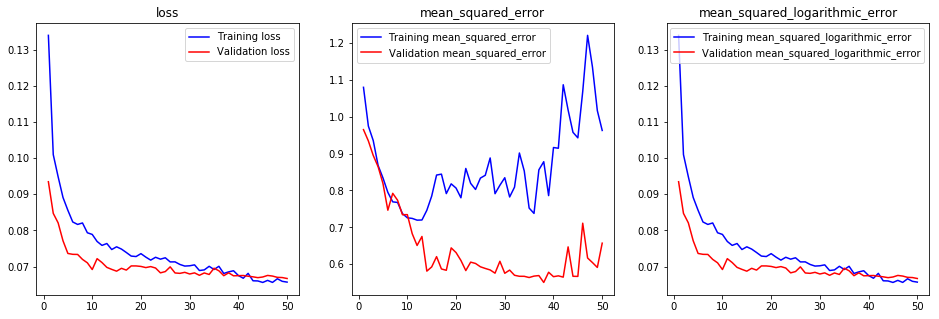

In [32]:
plot_history(hist)

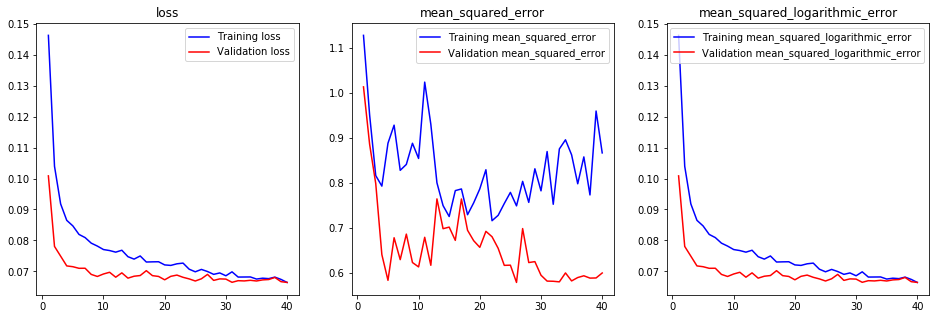

In [75]:
plot_history(hist)

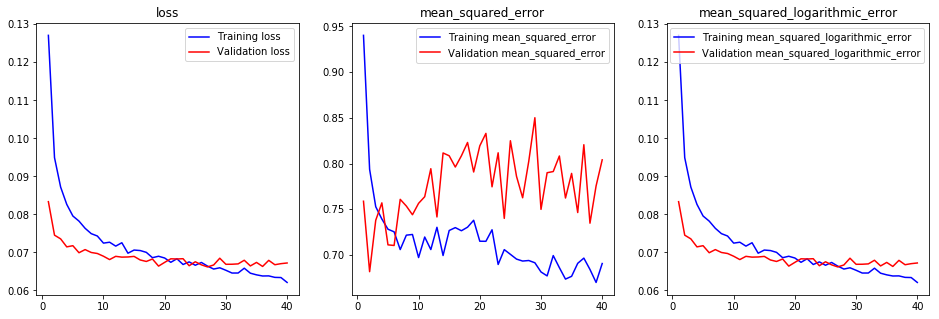

In [70]:
plot_history(hist)

In [33]:
# Evaluation
valid_pred_y = model.predict(valid_X)

# Scale predicted values back
scaled_valid_y = pt_cox_y.inverse_transform(valid_y[OUTPUT_NAME] - 1).astype(int)
scaled_valid_pred_y = pt_cox_y.inverse_transform(valid_pred_y - 1).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 2729.979943576183
rmsle: 2.068802625291884


# Prepare data for simple (non NN) models

In [11]:
# -- Train/Valid: train on part of train data and predict on valid
train_values_X= train_X[TEXT_FEATURES_INPUT_NAME]
train_values_y= train_y[OUTPUT_NAME]

valid_values_X= valid_X[TEXT_FEATURES_INPUT_NAME]
valid_values_y= valid_y[OUTPUT_NAME]

print('Train shape {:}'.format(train_values_X.shape, train_values_y.shape))
print('Valid shape {:}'.format(valid_values_X.shape, valid_values_y.shape))

Train shape (5994, 37)
Valid shape (1499, 37)


In [18]:
# -- Train/Test: train on all data and predict on test set --
alldataset_X= data_X[TEXT_FEATURES_INPUT_NAME]
alldataset_y= data_y[OUTPUT_NAME]

testset_X= test_X[TEXT_FEATURES_INPUT_NAME]

print('Train shape {:}'.format(alldataset_X.shape, alldataset_y.shape))
print('Valid shape {:}'.format(testset_X.shape))


Train shape (7493, 37)
Valid shape (2500, 37)


# RandomForestRegressor

In [19]:
# Found by random grid search
#{'bootstrap': True,
# 'max_depth': 100,
# 'max_features': 'auto',
# 'min_samples_leaf': 4,
# 'min_samples_split': 2,
# 'n_estimators': 1200}

# Best new
#{'bootstrap': True,
# 'max_depth': 80,
# 'max_features': 'auto',
# 'min_samples_leaf': 4,
# 'min_samples_split': 2,
# 'n_estimators': 944}

# Random Forest
from sklearn.ensemble import RandomForestRegressor


reg_forest = RandomForestRegressor(bootstrap=True,
                                   max_depth=80,
                                   max_features='auto',
                                   min_samples_leaf=4,
                                   min_samples_split=2,
                                   n_estimators=944,
                                   random_state=42,
                                   verbose=1)

reg_forest.fit(train_values_X, train_values_y)

valid_pred_y = reg_forest.predict(valid_values_X)

c:\users\aelimame\.conda\envs\ift6758\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


In [20]:
# Evaluation
valid_pred_y
# Scale predicted values back
scaled_valid_y = pt_cox_y.inverse_transform(valid_values_y.reshape(-1,1) - 1).astype(int)
scaled_valid_pred_y = pt_cox_y.inverse_transform(valid_pred_y.reshape(-1,1) - 1).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 4930.303511327595
rmsle: 1.7919275562664698


# RANDOM FOREST train on all data and Predict on test

In [18]:
# RANDOM FOREST using Text features only

# Params Found by random grid search
#{'bootstrap': True,
# 'max_depth': 100,
# 'max_features': 'auto',
# 'min_samples_leaf': 4,
# 'min_samples_split': 2,
# 'n_estimators': 1200}

# Train Random Forest
from sklearn.ensemble import RandomForestRegressor
reg_forest = RandomForestRegressor(bootstrap=True,
                                   max_depth=100,
                                   max_features='auto',
                                   min_samples_leaf=4,
                                   min_samples_split=2,
                                   n_estimators=1200,
                                   random_state=42,
                                   verbose=1)
reg_forest.fit(alldataset_X, alldataset_y)

# Predict on Test set
test_pred_y = reg_forest.predict(testset_X)

# Scale predicted values to int
scaled_test_pred_y = sc_alldata_y.inverse_transform(test_pred_y.reshape(-1,1)).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_test_pred_y < 0)
scaled_test_pred_y[idexes] = 0


c:\users\aelimame\.conda\envs\ift6758\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    0.6s finished


In [21]:
all_test_profiles_ids_list

array(['49I3SOKLI2CMNGP4', '727IRIR59A3P88LK', 'LN95SD15SRPCEE8F', ...,
       'SRNIBIK27BQ2M3PB', '6CP232J9R8N84702', 'AROR24MH3M79EHBS'],
      dtype=object)

In [22]:
# Store in DataFrame and save predictions
test_pd = pd.DataFrame()
test_pd['Id'] = all_test_profiles_ids_list
test_pd['Predicted'] = scaled_test_pred_y

test_tosubmit_folder = os.path.join(log_folder,'v2-cox-box-on-likes-fix-trsfrmX')
# Create log folder if does not exist
if not Path(test_tosubmit_folder).exists():
    os.mkdir(test_tosubmit_folder)
test_name = 'RaForestReg-HyperParamSearched-CoxBoxY-gitversion-xxxx-2020-11-28'
test_pd.to_csv(os.path.join(test_tosubmit_folder, test_name+'.csv'), sep=',', index=False)

# Cross validation and param search on models
# In progress

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, None], 'bootstrap': [True, False], 'max_features': ['auto', None]}


In [24]:
# put shape back to (nbr_samples,) instead of (nbr_samples, 1)
alldataset_y = alldataset_y.reshape(-1)

In [25]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Define custom scorer based on rmsle
scorer = make_scorer(rmsle, greater_is_better=False)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               scoring = scorer,
                               n_iter = 500,
                               cv = 5,
                               verbose = 3,
                               random_state = 42,
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(alldataset_X, alldataset_y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 56.2min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 97.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 154.3min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 215.5min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 297.0min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 398.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 491.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [26]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 944}

In [37]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1200}

# xgboost

In [187]:
#xgboost

#xgb_model = xgb.XGBRegressor(#objective='reg:squarederror',
#                                max_depth=100,
#                                n_estimators=1200,
#                            random_state=42)
#xgb_model.fit(train_values_X, train_values_y, eval_set=[(valid_values_X, valid_values_y)])

#valid_pred_y = xgb_model.predict(valid_values_X)


In [43]:
# Evaluation

# Scale predicted values back
scaled_valid_y = pt_cox_y.inverse_transform(valid_values_y.reshape(-1,1) - 1).astype(int)
scaled_valid_pred_y = pt_cox_y.inverse_transform(valid_pred_y.reshape(-1,1) - 1).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 5025.431775182906
rmsle: 1.8417445430812673


In [55]:
# Evaluation

# Scale predicted values back
scaled_valid_y = pt_cox_y.inverse_transform(valid_values_y.reshape(-1,1) - 1).astype(int)
scaled_valid_pred_y = pt_cox_y.inverse_transform(valid_pred_y.reshape(-1,1) - 1).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 5029.2000459385235
rmsle: 1.8417511055614149


# AdaBoost

In [69]:
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor

reg_ada = AdaBoostRegressor(n_estimators=500,
                             learning_rate=0.01,
                             loss='square',
                             random_state=42)

reg_ada.fit(train_values_X, train_values_y)

valid_pred_y = reg_ada.predict(valid_values_X)


c:\users\aelimame\.conda\envs\ift6758\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [70]:
# Evaluation

# Scale predicted values back
scaled_valid_y = pt_cox_y.inverse_transform(valid_values_y.reshape(-1,1) - 1).astype(int)
scaled_valid_pred_y = pt_cox_y.inverse_transform(valid_pred_y.reshape(-1,1) - 1).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 5214.789537454664
rmsle: 2.090629201480381


# BaggingRegressor

In [19]:
# BaggingRegressor

# Best Random search
#{'bootstrap': True,
# 'bootstrap_features': False,
# 'max_features': 1.0,
# 'max_samples': 1.0,
# 'n_estimators': 914}

from sklearn.ensemble import BaggingRegressor

bagg = BaggingRegressor(n_estimators=914,
                        bootstrap=True,
                        bootstrap_features=False,
                        max_features=1.0,
                        max_samples=1.0,
                        random_state=42)
bagg.fit(train_values_X,train_values_y)

valid_pred_y = bagg.predict(valid_values_X)

c:\users\aelimame\.conda\envs\ift6758\lib\site-packages\sklearn\ensemble\bagging.py:398: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


In [20]:
# Evaluation

# Scale predicted values back
scaled_valid_y = pt_cox_y.inverse_transform(valid_values_y.reshape(-1,1) - 1).astype(int)
scaled_valid_pred_y = pt_cox_y.inverse_transform(valid_pred_y.reshape(-1,1) - 1).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 4910.6942022181
rmsle: 1.7997235013265478


In [93]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# Number of estimators
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 15)]

# Maximum samples
max_samples = [x for x in np.linspace(start = 0.25, stop = 1.0, num = 5)]

# Number of features
max_features = [x for x in np.linspace(start = 0.25, stop = 1.0, num = 5)]

# Bootstrap
bootstrap = [True, False]

# Bootstrap_features
bootstrap_features = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_samples': max_samples,
               'max_features': max_features,
               'bootstrap': bootstrap,
               'bootstrap_features': bootstrap_features}
print(random_grid)

{'bootstrap_features': [True, False], 'n_estimators': [100, 235, 371, 507, 642, 778, 914, 1050, 1185, 1321, 1457, 1592, 1728, 1864, 2000], 'max_samples': [0.25, 0.4375, 0.625, 0.8125, 1.0], 'bootstrap': [True, False], 'max_features': [0.25, 0.4375, 0.625, 0.8125, 1.0]}


In [94]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
breg = BaggingRegressor()

# Define custom scorer based on rmsle
scorer = make_scorer(rmsle, greater_is_better=False)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
random = RandomizedSearchCV(estimator = breg,
                               param_distributions = random_grid,
                               scoring = scorer,
                               n_iter = 500,
                               cv = 5,
                               verbose = 3,
                               random_state = 42,
                               n_jobs = -1)
# Fit the random search model
random.fit(alldataset_X, alldataset_y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 58.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 91.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 135.9min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 188.7min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 258.8min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 325.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=BaggingRegressor(base_estimator=None,
                                              bootstrap=True,
                                              bootstrap_features=False,
                                              max_features=1.0, max_samples=1.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
                   iid='warn', n_iter=500, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'bootstrap_features': [True, False],
                                        'max_features': [0.25, 0.4375, 0.625,
                                                         0.8125, 1.0],
                                

In [21]:
# Best Random search
#{'bootstrap': True,
# 'bootstrap_features': False,
# 'max_features': 1.0,
# 'max_samples': 1.0,
# 'n_estimators': 914}

In [95]:
random.best_params_

{'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 914}

# Gradient Boosting Regressor

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(train_values_X,train_values_y)

valid_pred_y = gbr.predict(valid_values_X)

c:\users\aelimame\.conda\envs\ift6758\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
# Evaluation

# Scale predicted values back
scaled_valid_y = pt_cox_y.inverse_transform(valid_values_y.reshape(-1,1) - 1).astype(int)
scaled_valid_pred_y = pt_cox_y.inverse_transform(valid_pred_y.reshape(-1,1) - 1).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_valid_pred_y < 0)
scaled_valid_pred_y[idexes] = 0

# Compute rmse and rmsle
rmse_val = np.sqrt(mean_squared_error(scaled_valid_pred_y, scaled_valid_y))
print('sqrt mse: {:}'.format(rmse_val))
rmsle_val = rmsle(scaled_valid_pred_y, scaled_valid_y)
print('rmsle: {:}'.format(rmsle_val))

sqrt mse: 5064.855748505458
rmsle: 1.7780788985069138


In [167]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# Random shearch
# Number of estimators
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]

# Number of features to consider at every split
max_features = [None]#['auto', 'sqrt', 'log2', None]

# Maximum number of levels
max_depth = [int(x) for x in np.linspace(1, 2, num = 2)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 3, num = 2)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 2, num = 2)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'max_depth': [1, 2, None], 'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 3], 'max_features': [None], 'min_samples_leaf': [1, 2]}


In [129]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbr = GradientBoostingRegressor()

# Define custom scorer based on rmsle
scorer = make_scorer(rmsle, greater_is_better=False)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
random = RandomizedSearchCV(estimator = gbr,
                               param_distributions = random_grid,
                               scoring = scorer,
                               n_iter = 50,
                               cv = 5,
                               verbose = 3,
                               random_state = 42,
                               n_jobs = -1)
# Fit the random search model
random.fit(alldataset_X, alldataset_y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 15.0min finished
c:\users\aelimame\.conda\envs\ift6758\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [130]:
random.best_params_

{'max_depth': 2,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

# Gradient Boosting Regressor train on all data and predict on Test

In [28]:
# RANDOM FOREST using Text features only

# Train Random Forest
from sklearn.ensemble import RandomForestRegressor

gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(alldataset_X, alldataset_y)

# Predict on Test set
test_pred_y = gbr.predict(testset_X)

# Scale predicted values to int
scaled_test_pred_y = sc_alldata_y.inverse_transform(test_pred_y.reshape(-1,1)).astype(int)

# Make sure predicted and scaled back values are not negatives!
idexes = np.nonzero(scaled_test_pred_y < 0)
scaled_test_pred_y[idexes] = 0


c:\users\aelimame\.conda\envs\ift6758\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
# Store in DataFrame and save predictions
test_pd = pd.DataFrame()
test_pd['Id'] = all_test_profiles_ids_list
test_pd['Predicted'] = scaled_test_pred_y

test_tosubmit_folder = os.path.join(log_folder,'v3-cox-box-on-likes-GBR')
# Create log folder if does not exist
if not Path(test_tosubmit_folder).exists():
    os.mkdir(test_tosubmit_folder)
test_name = 'GBReg-Default-RandState42-CoxBoxY-gitversion-xxxx-2020-11-29'
test_pd.to_csv(os.path.join(test_tosubmit_folder, test_name+'.csv'), sep=',', index=False)

In [ ]:
# Voting models